In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-dataset/train-images.idx3-ubyte
/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte
/kaggle/input/mnist-dataset/train-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte
/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte


In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import struct
from PIL import Image

## CNN DATASET 

In [53]:
class MNISTDataset(Dataset):
    def __init__(self, images_path, labels_path, image_size=28):
        self.images_path = images_path
        self.labels_path = labels_path
        self.image_size = image_size

        self.images = self._read_images(self.images_path)
        self.labels = self._read_labels(self.labels_path)

        self.transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

    def _read_images(self, filepath):
        with open(filepath, 'rb') as f:
            magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
            images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, 28, 28)
        return images

    def _read_labels(self, filepath):
        with open(filepath, 'rb') as f:
            magic, num = struct.unpack(">II", f.read(8))
            labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = Image.fromarray(image, mode='L')

        if self.transform:
            image = self.transform(image)

        return image, label

## CNN CLASSIFIER

In [54]:
class MnistClassifier(nn.Module):

	def __init__(self, num_classes=10):
		super(MnistClassifier, self).__init__()

		self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
		self.pool = nn.MaxPool2d(2, 2)

		self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
		self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

		self.fc1 = nn.Linear(64 * 3 * 3, 64)
		self.fc2 = nn.Linear(64, num_classes)

	def forward(self, x):
		x = self.conv1(x)
		x = F.relu(x)
		x = self.pool(x)

		x = self.conv2(x)
		x = F.relu(x)
		x = self.pool(x)

		x = self.conv3(x)
		x = F.relu(x)
		x = self.pool(x)

		x = x.view(x.size(0), -1)
		x = self.fc1(x)
		x = F.relu(x)

		x = self.fc2(x)

		return x

In [55]:
import argparse
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

train_dataset = MNISTDataset(
	    images_path='/kaggle/input/mnist-dataset/train-images.idx3-ubyte',
	    labels_path='/kaggle/input/mnist-dataset/train-labels.idx1-ubyte'
	)

test_dataset = MNISTDataset(
	    images_path='/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte',
	    labels_path='/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte'
	)

batch_size = 8
test_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=test_batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 10

model = MnistClassifier(num_classes)
model = model.to(device)

## Fungsi Loss Dan Algoritma Optimizer

In [56]:
# fungsi loss
criterion = nn.CrossEntropyLoss()

# algoritma optimasi
# gradient descent 
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

## Menghitung Jumlah Paramater Yng DIOptimasi

In [57]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params / 1e6:.2f}M")
print(f"Trainable parameters: {trainable_params / 1e6:.2f}M")

Total parameters: 0.06M
Trainable parameters: 0.06M


Epoch 1: 100%|██████████| 7500/7500 [00:27<00:00, 276.14it/s]


Epoch 1: Train Loss 0.0000, Test Loss 0.0930, Test Acc 0.9728


Epoch 2: 100%|██████████| 7500/7500 [00:27<00:00, 275.93it/s]


Epoch 2: Train Loss 0.0000, Test Loss 0.0563, Test Acc 0.9816


Epoch 3: 100%|██████████| 7500/7500 [00:27<00:00, 273.98it/s]


Epoch 3: Train Loss 0.0000, Test Loss 0.0443, Test Acc 0.9861


Epoch 4: 100%|██████████| 7500/7500 [00:27<00:00, 273.76it/s]


Epoch 4: Train Loss 0.0000, Test Loss 0.0384, Test Acc 0.9874


Epoch 5: 100%|██████████| 7500/7500 [00:27<00:00, 275.35it/s]


Epoch 5: Train Loss 0.0000, Test Loss 0.0317, Test Acc 0.9893


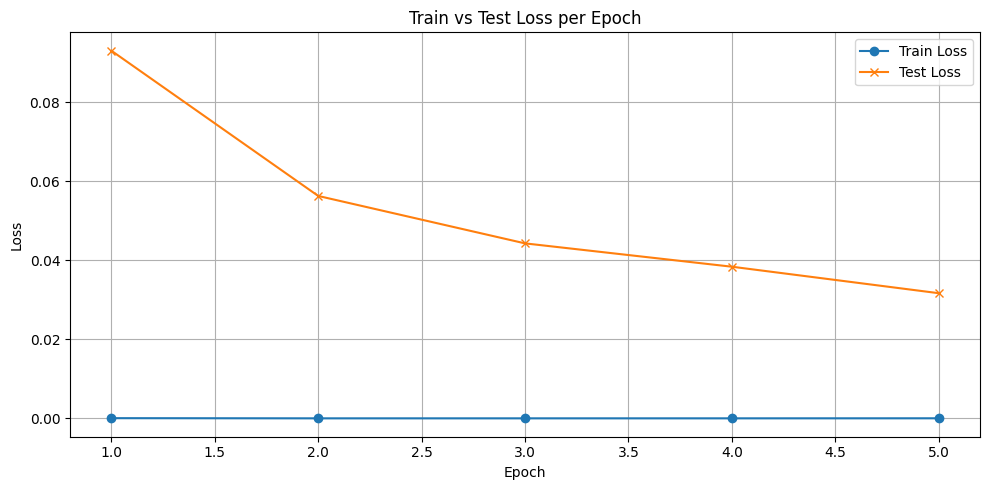

In [58]:
train_losses = []
test_losses = []

epochs = 5
checkpoint = 'model_checkpoint.pth'

for epoch in range(epochs):
		model.train()
		train_loss = 0

		for data, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
			data, labels = data.to(device), labels.to(device)
			optimizer.zero_grad()
			outputs = model(data)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
		
		train_loss += loss.item() * data.size(0)

		model.eval()
		correct = 0
		total = 0
		test_loss = 0

		with torch.no_grad():
			for data, labels in test_loader:
				data, labels = data.to(device), labels.to(device)
				outputs = model(data)
				loss = criterion(outputs, labels)
				test_loss += loss.item() * data.size(0)
				_, preds = torch.max(outputs, 1)
				correct += (preds == labels).sum().item()
				total += labels.size(0)

		acc = correct / total
		avg_train_loss = train_loss / len(train_dataset)
		avg_test_loss = test_loss / len(test_dataset)

		train_losses.append(avg_train_loss)
		test_losses.append(avg_test_loss)

		print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f}, Test Loss {avg_test_loss:.4f}, Test Acc {acc:.4f}")

torch.save({
	'epoch': epochs,
	'model_state_dict': model.state_dict(),
	'optimizer_state_dict': optimizer.state_dict(),
	'train_loss': train_losses,
	'test_loss': test_losses,
}, checkpoint)

epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_range, test_losses, label='Test Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()